In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.append(os.environ['raco'])
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['rapl'])
from common import *
from plotcommon import *
from cla_util import *
from rayleigh_diagnostics import GridInfo

In [2]:
dirname = '/nobackup/lmatilsk/benchmarks/c2001_case0/00_test_equations/'

In [3]:
the_file = get_widest_range_file (dirname + 'data/', 'Point_Probes_trace')
print ('the_file = ', the_file)

the_file =  /nobackup/lmatilsk/benchmarks/c2001_case0/00_test_equations/data/Point_Probes_trace-00100001_00100100.pkl


In [4]:
# get point probes data
di = get_dict(the_file)
vals = di['vals']

times = di['times']
dt = times[2:] - times[1:-1]
dt = dt.reshape((len(dt), 1, 1, 1))
dt_old = times[1:-1] - times[:-2]
dt_old = dt_old.reshape((len(dt_old), 1, 1, 1))

iters = di['iters']
lut = di['lut']
rvals = di['rvals']
thetavals = di['thetavals']
phivals = di['phivals']

# get grid info
di_grid = get_grid_info(dirname)
rr = di_grid['rr']
tt = di_grid['tt']
phi = di_grid['phi']
tt_lat = di_grid['tt_lat']
lons = di_grid['lons']

irvals = inds_from_vals(rr, rvals)
ithetavals = inds_from_vals(tt, thetavals)
iphivals = inds_from_vals(phi, phivals)

print ('nphi =', di_grid['nphi'])
print ('iphivals = ', iphivals)

print ('ntheta =', di_grid['nt'])
print ('ithetavals = ', ithetavals)

print('nr =', di_grid['nr'])
print ('irvals = ', irvals)

nphi = 128
iphivals =  [  0  16  32  48  63  79  95 111]
ntheta = 64
ithetavals =  [ 3  8 16 24 32 39 47 55 60]
nr = 48
irvals =  [ 4  7 11 13 15 18 20 21 22 23 24 25 27 29 32 34 36 40 43]


In [5]:
prot = compute_Prot(dirname)
t = times/prot

In [6]:
np.diff(times)

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04])

In [7]:
# thermo state
eq = get_eq(dirname)

In [8]:
def my_maxabs(*args):
    the_shape = np.shape(args[0])
    maxabs = np.zeros(the_shape) - np.inf
    for arg in args:
        maxabs = np.maximum(maxabs, arg)
    return maxabs

In [9]:
# r momentum 
rhov_r = vals[..., lut[201]]

adv_r = -vals[..., lut[1201]]
cor_r = vals[..., lut[1219]]
fexp_r = adv_r + cor_r

visc_r = vals[..., lut[1228]]
gradp_r = vals[..., lut[1237]]
buoy = vals[..., lut[1216]]
fimp_r = buoy + visc_r + gradp_r

# max abs (to normalize later)
maxabs_r = my_maxabs(np.abs(adv_r), np.abs(cor_r), np.abs(visc_r), np.abs(gradp_r))

In [10]:
# theta momentum
rhov_t = vals[..., lut[202]]

adv_t = -vals[..., lut[1202]]
cor_t = vals[..., lut[1220]]
fexp_t = adv_t + cor_t

visc_t = vals[..., lut[1229]]
gradp_t = vals[..., lut[1238]]
fimp_t = visc_t + gradp_t

maxabs_t = my_maxabs(np.abs(adv_t), np.abs(cor_t), np.abs(visc_t), np.abs(gradp_t))

In [11]:
# phi momentum
rhov_p = vals[..., lut[203]]

adv_p = -vals[..., lut[1203]]
cor_p = vals[..., lut[1221]]
fexp_p = adv_p + cor_p

visc_p = vals[..., lut[1230]]
gradp_p = vals[..., lut[1239]]
fimp_p = visc_p + gradp_p

maxabs_p = my_maxabs(np.abs(adv_p), np.abs(cor_p), np.abs(visc_p), np.abs(gradp_p))

In [12]:
# heat equation
rhot = (eq.rho*eq.T)[irvals]
rhot = rhot.reshape((1, 1, 1, len(rhot)))
tdsdr = (eq.T*eq.dsdr)[irvals]
tdsdr = tdsdr.reshape((1, 1, 1, len(tdsdr)))

inte = vals[..., lut[701]]
dy = inte[2:] - inte[1:-1]
dintedt = dy/dt

adv_heat = -vals[..., lut[1401]]
int_heat = vals[..., lut[1434]]
visc_heat = vals[..., lut[1435]]*rhot
#joule_heating = vals[..., lut[1436]]*rhot
fexp_heat = adv_heat + int_heat + visc_heat# + joule_heating

ref_adv_heat = -rhov_r*tdsdr
cond_heat = vals[..., lut[1421]]
fimp_heat = ref_adv_heat + cond_heat

maxabs_heat = my_maxabs(np.abs(adv_heat), np.abs(int_heat), np.abs(visc_heat), np.abs(ref_adv_heat), cond_heat)

In [13]:
# get d lhs / dt
dy = rhov_r[2:] - rhov_r[1:-1]
drhovdt_r = dy/dt

dy = rhov_t[2:] - rhov_t[1:-1]
drhovdt_t = dy/dt

dy = rhov_p[2:] - rhov_p[1:-1]
drhovdt_p = dy/dt

In [14]:
np.shape(vals)

(100, 8, 9, 19, 44)

In [15]:
# start getting weighted rhs

def get_weighted_rhs(fimp, fexp):
    return 0.5*(fimp[2:] + fimp[1:-1]) + fexp[1:-1] + 0.5*(dt/dt_old)*(fexp[1:-1] - fexp[:-2])

fweighted_r = get_weighted_rhs(fimp_r, fexp_r)
fweighted_t = get_weighted_rhs(fimp_t, fexp_t)
fweighted_p = get_weighted_rhs(fimp_p, fexp_p)
fweighted_heat = get_weighted_rhs(fimp_heat, fexp_heat)

Text(0.5, 1.0, 'momentum (r)')

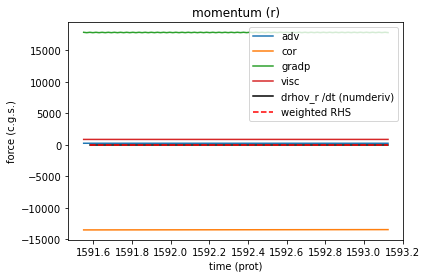

In [16]:
# plot r momentum (all pieces)

# pick a point
iphi0, it0, ir0 = 4, 5, 11

# pieces
plt.plot(t, adv_r[:, iphi0, it0, ir0], label='adv')
plt.plot(t, cor_r[:, iphi0, it0, ir0], label='cor')
plt.plot(t, gradp_r[:, iphi0, it0, ir0], label='gradp')
plt.plot(t, visc_r[:, iphi0, it0, ir0], label='visc')

# totals
plt.plot(t[2:], drhovdt_r[:, iphi0, it0, ir0], 'k', label='drhov_r /dt (numderiv)')
plt.plot(t[2:], fweighted_r[:, iphi0, it0, ir0], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum (r)')

Text(0.5, 1.0, 'momentum totals (r)')

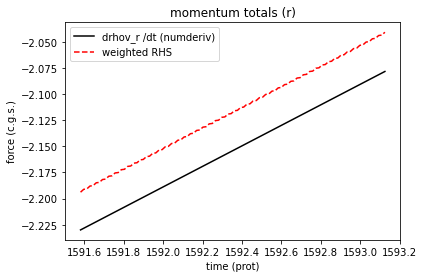

In [17]:
# plot r momentum (totals)
plt.plot(t[2:], drhovdt_r[:, iphi0, it0, ir0], 'k', label='drhov_r /dt (numderiv)')
plt.plot(t[2:], fweighted_r[:, iphi0, it0, ir0], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum totals (r)')

Text(0.5, 1.0, 'momentum (t)')

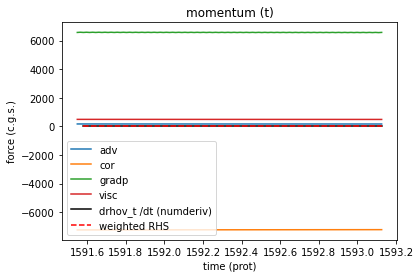

In [18]:
# plot theta momentum (all pieces)

# pieces
plt.plot(t, adv_t[:, iphi0, it0, ir0], label='adv')
plt.plot(t, cor_t[:, iphi0, it0, ir0], label='cor')
plt.plot(t, gradp_t[:, iphi0, it0, ir0], label='gradp')
plt.plot(t, visc_t[:, iphi0, it0, ir0], label='visc')

# totals
plt.plot(t[2:], drhovdt_t[:, iphi0, it0, ir0], 'k', label='drhov_t /dt (numderiv)')
plt.plot(t[2:], fweighted_t[:, iphi0, it0, ir0], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum (t)')

Text(0.5, 1.0, 'momentum totals (t)')

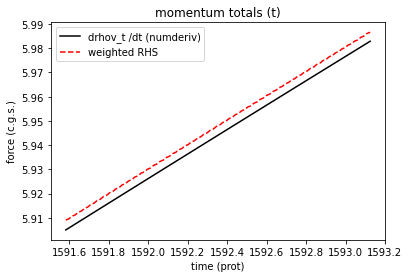

In [19]:
# plot r momentum (totals)
plt.plot(t[2:], drhovdt_t[:, iphi0, it0, ir0], 'k', label='drhov_t /dt (numderiv)')
plt.plot(t[2:], fweighted_t[:, iphi0, it0, ir0], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum totals (t)')

Text(0.5, 1.0, 'momentum (p)')

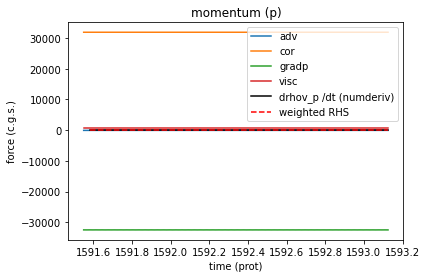

In [20]:
# plot phi momentum (all pieces)

# pieces
plt.plot(t, adv_p[:, iphi0, it0, ir0], label='adv')
plt.plot(t, cor_p[:, iphi0, it0, ir0], label='cor')
plt.plot(t, gradp_p[:, iphi0, it0, ir0], label='gradp')
plt.plot(t, visc_p[:, iphi0, it0, ir0], label='visc')

# totals
plt.plot(t[2:], drhovdt_p[:, iphi0, it0, ir0], 'k', label='drhov_p /dt (numderiv)')
plt.plot(t[2:], fweighted_p[:, iphi0, it0, ir0], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum (p)')

Text(0.5, 1.0, 'momentum totals (p)')

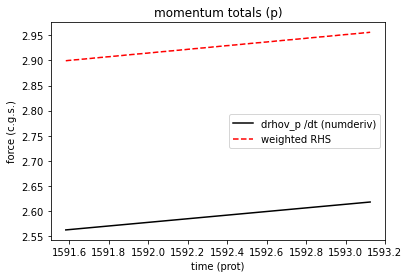

In [21]:
# plot r momentum (totals)
plt.plot(t[2:], drhovdt_p[:, iphi0, it0, ir0], 'k', label='drhov_p /dt (numderiv)')
plt.plot(t[2:], fweighted_p[:, iphi0, it0, ir0], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum totals (p)')

Text(0.5, 1.0, 'heat eq.')

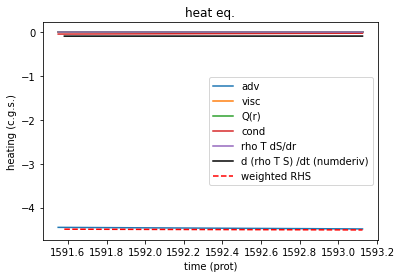

In [22]:
# plot heat equation (all pieces)

# pieces
plt.plot(t, adv_heat[:, iphi0, it0, ir0], label='adv')
plt.plot(t, visc_heat[:, iphi0, it0, ir0], label='visc')
plt.plot(t, int_heat[:, iphi0, it0, ir0], label='Q(r)')
plt.plot(t, cond_heat[:, iphi0, it0, ir0], label='cond')
plt.plot(t, ref_adv_heat[:, iphi0, it0, ir0], label='rho T dS/dr')

# totals
plt.plot(t[2:], dintedt[:, iphi0, it0, ir0], 'k', label='d (rho T S) /dt (numderiv)')
plt.plot(t[2:], fweighted_heat[:, iphi0, it0, ir0], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('heating (c.g.s.)')
plt.title('heat eq.')

In [23]:
# heat equation
inte = vals[:, iiphi0, iit0, iir0, lut[701]]
dy = inte[2:] - inte[1:-1]
dintedt = dy/dt

adv_heat = -vals[:, iiphi0, iit0, iir0, lut[1401]]
ref_adv_heat = -rhovr*(eq.T*eq.dsdr)[ir0]
cond_heating = vals[:, iiphi0, iit0, iir0, lut[1421]]
int_heating = vals[:, iiphi0, iit0, iir0, lut[1434]]
visc_heating = vals[:, iiphi0, iit0, iir0, lut[1435]]*rhot[iir0]
joule_heating = vals[:, iiphi0, iit0, iir0, lut[1436]]*rhot[iir0]

f_exp = adv_heat + visc_heating + joule_heating
f_imp = ref_adv_heat + cond_heating + int_heating
f_weighted = 0.5*(f_imp[2:] + f_imp[1:-1]) + f_exp[1:-1] + 0.5*(dt/dt_old)*(f_exp[1:-1] - f_exp[:-2])

plt.plot(t[2:], dintedt, 'k', label='d [INTE] /dt (numderiv)')
plt.plot(t[2:], f_weighted, 'r--', label='weighted RHS')
#plt.plot(t, f_r/rho[ir0], label='weighted RHS')
plt.plot(t[2:], f_weighted - dintedt, 'g', label='difference')

plt.legend()

NameError: name 'iiphi0' is not defined

In [ ]:
# check numerical errors in the momentum equation
print ("err mom r = ", rms(rhs_momr - drhovrdt)/rms(drhovrdt))
print ("err mom t = ", rms(rhs_momt - drhovtdt)/rms(drhovtdt))
print ("err mom p = ", rms(rhs_momp - drhovpdt)/rms(drhovpdt))